In [200]:
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools

VINA = True  # set this to True or False

data_dirs = ["../Data/other/SDF poses"]

data = []

for sdf_dir in data_dirs:
    for filename in os.listdir(sdf_dir):
        if filename.endswith(".sdf"):
            name = filename[:-4]
            if not VINA and "_-" in name:
                continue  # skip VINA poses if VINA=False
            sdf_path = os.path.join(sdf_dir, filename)
            suppl = Chem.SDMolSupplier(sdf_path)
            for mol in suppl:
                if mol:
                    smiles = Chem.MolToSmiles(mol)
                    data.append({
                        "name": name,
                        "smiles": smiles,
                        "source": os.path.basename(sdf_dir)
                    })

df = pd.DataFrame(data)
PandasTools.AddMoleculeColumnToFrame(frame=df, smilesCol='smiles')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    46 non-null     object
 1   smiles  46 non-null     object
 2   source  46 non-null     object
 3   ROMol   46 non-null     object
dtypes: object(4)
memory usage: 1.6+ KB


In [201]:
# load from csv if it exists
csv_path = "../Data/docs/8.PLIP_poses.csv"
df_plip = pd.read_csv(csv_path)

# rename Pose_ID to name
df_plip.rename(columns={"Pose_ID": "name"}, inplace=True)

# merge with the main dataframe
df = pd.merge(df, df_plip, on='name', how='left')
df.head()

,name,smiles,source,ROMol,hbondd_HIS_268_A,hydroph_PHE_267_A,hydroph_LEU_328_A,hydroph_ASP_339_A,hydroph_LYS_196_A,hydroph_VAL_204_A,...,saltbridge_GLU_230_A,saltbridge_LYS_325_A,hbondd_ARG_198_A,hbonda_SER_272_A,hbonda_ASP_321_A,hbonda_GLU_230_A,hbonda_ARG_198_A,hbondd_LYS_217_A,saltbridge_GLU_194_A,hydroph_GLU_194_A
0,B4B_5OXG,c1cc(-c2cnn3cc(-c4ccc(N5CCNCC5)cc4)cnc23)c2ccc...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x152ed20a0>,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
1,C9U_6JUX,CCn1cc(-c2ccnc(Nc3ccc(N4CCNCC4)cc3)n2)c(-c2ccc...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x15347cdd0>,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,False
2,H8H_6ZGC,CN1CCN(CCOc2cc(OC3CCOCC3)c3c(Nc4c(Cl)ccc5c4OCO...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x15347d380>,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,XQX_8UWR,O=C(C1CC1)N1CCN(c2ccnn3cc(-c4ccc(N5CCNCC5)cc4)...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x15347f450>,True,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
4,CUIH_-9.462,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,SDF poses,<rdkit.Chem.rdchem.Mol object at 0x15347e3b0>,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False


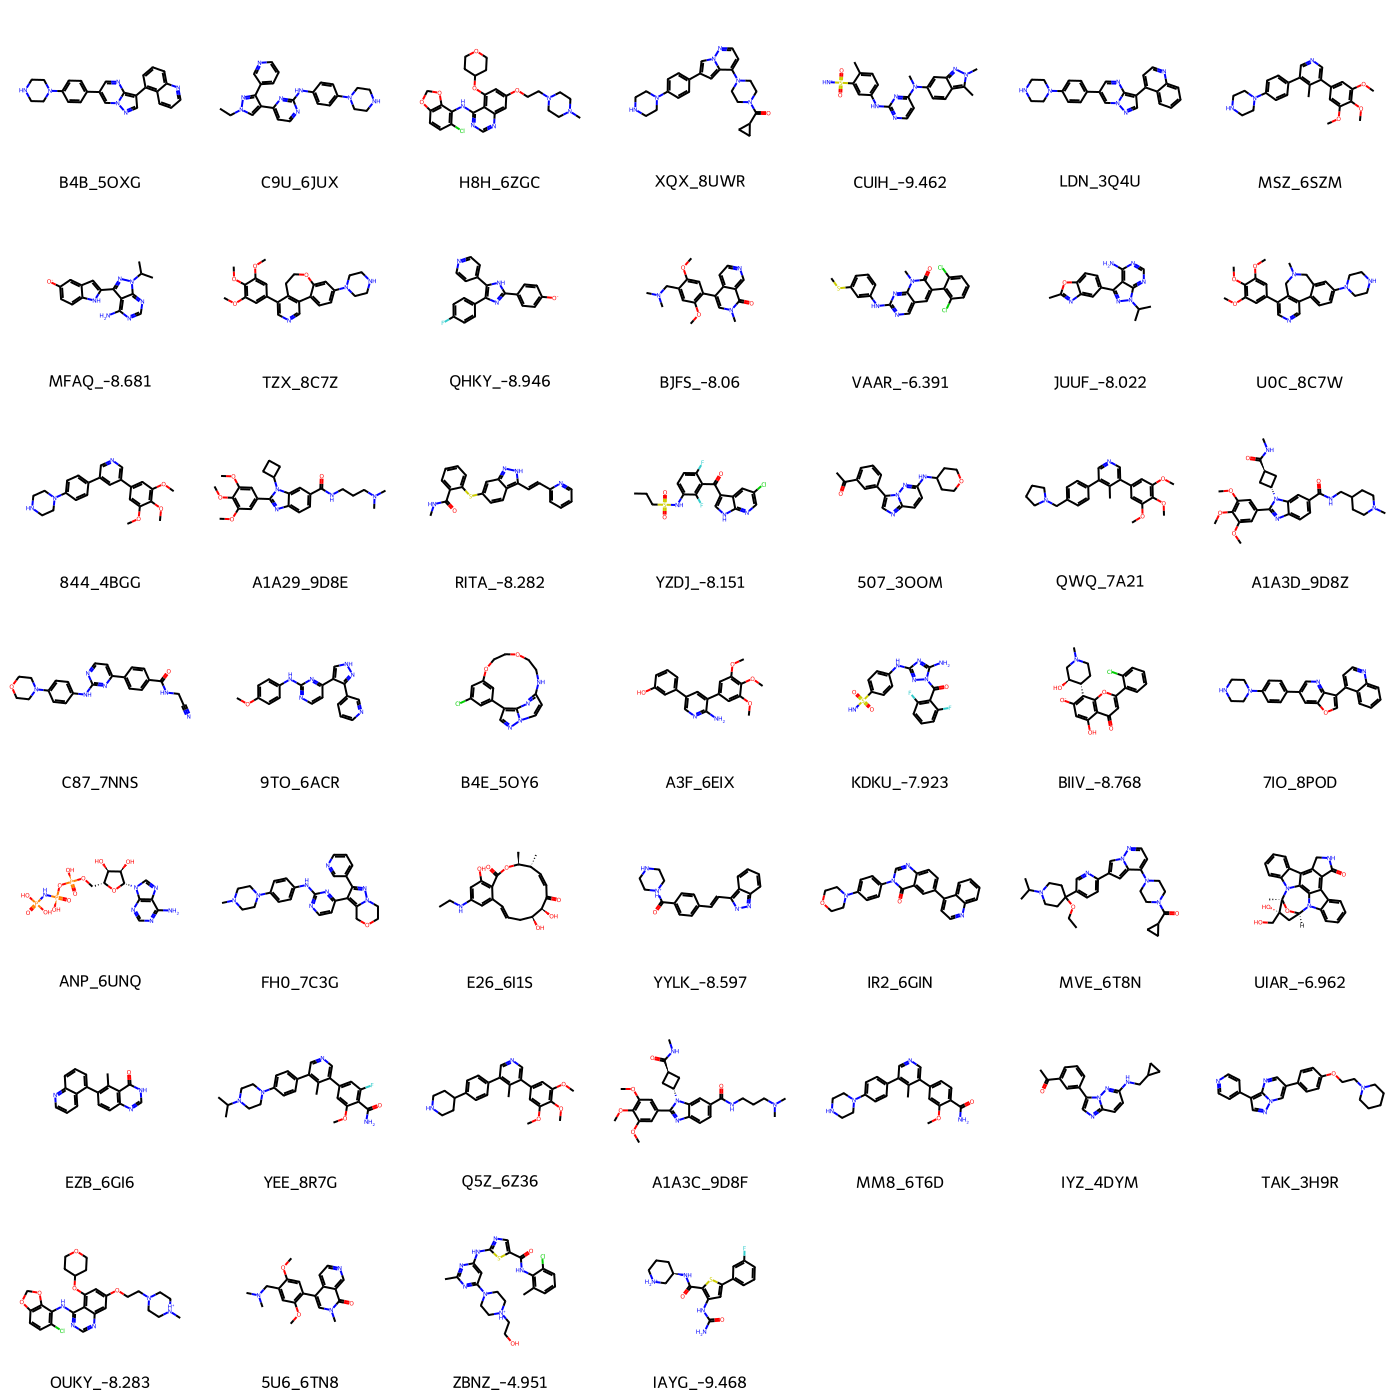

In [202]:
from rdkit.Chem import Draw

# Draw first 10 molecules
names = df['name'].tolist()
mols = [Chem.MolFromSmiles(smiles) for smiles in df['smiles']]
img = Draw.MolsToGridImage(mols, molsPerRow=7, subImgSize=(200,200), legends=names)
img

In [ ]:
with open("../Results/images/Pharmacophore compounds.png", "wb") as png:
    png.write(img.data)

In [203]:
from rdkit.Chem import AllChem

def morgan_fp(mol):
    morgan = AllChem.GetMorganGenerator(radius=2, fpSize=512)
    return morgan.GetFingerprint(mol)

df['morgan'] = df['ROMol'].apply(morgan_fp)

In [232]:
from rdkit import DataStructs

def matrix_Tanimoto(mols):
    matrix = []

    for mol in mols:
        array_similaridade = DataStructs.BulkTanimotoSimilarity(mol, mols)
        matrix.append(array_similaridade)

    return pd.DataFrame(data=matrix)

tanimoto = matrix_Tanimoto(df['morgan'])
tanimoto

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,1.000000,0.350000,0.148515,0.400000,0.104167,0.882353,0.343284,0.132530,0.293333,0.188406,...,0.238095,0.200000,0.108911,0.315068,0.195122,0.357143,0.135922,0.119048,0.153061,0.122222
1,0.350000,1.000000,0.135135,0.317073,0.208333,0.358974,0.298701,0.168539,0.258824,0.135802,...,0.212766,0.176471,0.140187,0.292683,0.227273,0.220930,0.133929,0.142857,0.182692,0.132653
2,0.148515,0.135135,1.000000,0.126214,0.192308,0.140000,0.125000,0.131313,0.173469,0.086957,...,0.129630,0.125000,0.160714,0.128713,0.160000,0.241758,0.875000,0.154639,0.190909,0.133333
3,0.400000,0.317073,0.126214,1.000000,0.115789,0.411765,0.343284,0.160494,0.310811,0.154930,...,0.268293,0.232877,0.166667,0.371429,0.225000,0.217949,0.125000,0.146341,0.202128,0.160920
4,0.104167,0.208333,0.192308,0.115789,1.000000,0.106383,0.126437,0.159091,0.166667,0.125000,...,0.142857,0.152941,0.224490,0.142857,0.152174,0.119565,0.190476,0.228916,0.130841,0.147368
5,0.882353,0.358974,0.140000,0.411765,0.106383,1.000000,0.353846,0.121951,0.301370,0.176471,...,0.243902,0.205479,0.122449,0.323944,0.185185,0.367647,0.127451,0.121951,0.144330,0.112360
6,0.343284,0.298701,0.125000,0.343284,0.126437,0.353846,1.000000,0.131579,0.648148,0.121212,...,0.573770,0.640000,0.268293,0.760000,0.184211,0.191781,0.123711,0.228571,0.166667,0.107143
7,0.132530,0.168539,0.131313,0.160494,0.159091,0.121951,0.131579,1.000000,0.107143,0.258065,...,0.149425,0.162162,0.102041,0.164557,0.146341,0.109756,0.130000,0.111111,0.123711,0.114943
8,0.293333,0.258824,0.173469,0.310811,0.166667,0.301370,0.648148,0.107143,1.000000,0.094595,...,0.391892,0.459016,0.247191,0.507937,0.212500,0.146341,0.171717,0.256757,0.120000,0.098901
9,0.188406,0.135802,0.086957,0.154930,0.125000,0.176471,0.121212,0.258065,0.094595,1.000000,...,0.113924,0.174603,0.116279,0.126761,0.093333,0.179104,0.097826,0.114286,0.089888,0.133333


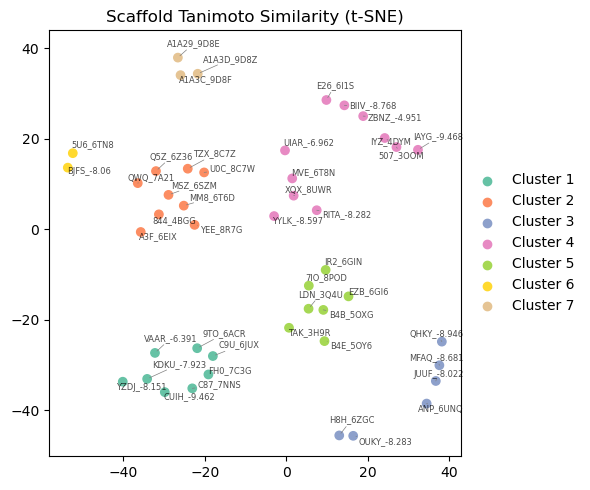

In [257]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from adjustText import adjust_text

tsne = TSNE(metric='precomputed', init='random', random_state=42, perplexity=5)
embedding_tsne = tsne.fit_transform(1 - tanimoto)

kmeans = KMeans(n_clusters=7, random_state=42)
labels_TSNE = kmeans.fit_predict(embedding_tsne)

cmap = plt.get_cmap('Set2')

plt.figure(figsize=(6, 5))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=cmap(labels_TSNE))
plt.title('Scaffold Tanimoto Similarity (t-SNE)')

texts = [plt.text(embedding_tsne[i, 0], embedding_tsne[i, 1], name, fontsize=6, alpha=0.7)
        for i, name in enumerate(df['name'])]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), force_text=1)


for i in range(7):
    plt.scatter([], [], color=cmap(i), label=f'Cluster {i+1}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.tight_layout()
plt.savefig("../Results/images/scaffold clusters T-SNE (Vina).png", dpi=300)
plt.show()


/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


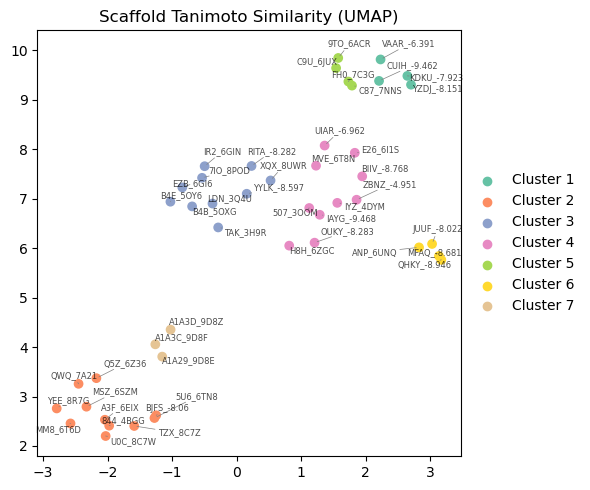

In [258]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Assuming your matrix is in a DataFrame called df
reducer = umap.UMAP(metric='precomputed', random_state=42, n_neighbors=5, min_dist=0.1)
embedding = reducer.fit_transform(1 - tanimoto)  # 1 - similarity = distance

kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(embedding)

cmap = plt.get_cmap('Set2')  # discrete colormap
colors = cmap(labels)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors)

# Add labels for each molecule (replace molecule_names with your list)
texts = [plt.text(embedding[i, 0], embedding[i, 1], name, fontsize=6, alpha=0.7)
        for i, name in enumerate(df['name'])]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), force_text=1)


for i in range(7):
    plt.scatter([], [], color=cmap(i), label=f'Cluster {i+1}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.title('Scaffold Tanimoto Similarity (UMAP)')
plt.tight_layout()
plt.savefig("../Results/images/scaffold clusters UMAP (Vina).png", dpi=300)
plt.show()

/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,name,smiles,source,ROMol,hbondd_HIS_268_A,hydroph_PHE_267_A,hydroph_LEU_328_A,hydroph_ASP_339_A,hydroph_LYS_196_A,hydroph_VAL_204_A,...,saltbridge_LYS_325_A,hbondd_ARG_198_A,hbonda_SER_272_A,hbonda_ASP_321_A,hbonda_GLU_230_A,hbonda_ARG_198_A,hbondd_LYS_217_A,saltbridge_GLU_194_A,hydroph_GLU_194_A,cluster
0,C9U_6JUX,CCn1cc(-c2ccnc(Nc3ccc(N4CCNCC4)cc3)n2)c(-c2ccc...,SDF poses,,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,1
1,CUIH_-9.462,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,SDF poses,,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,1
2,VAAR_-6.391,CSc1cccc(Nc2ncc3cc(-c4c(Cl)cccc4Cl)c(=O)n(C)c3...,SDF poses,,False,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,1
3,YZDJ_-8.151,CCCS(=O)(=O)Nc1ccc(F)c(C(=O)c2c[nH]c3ncc(Cl)cc...,SDF poses,,False,True,True,False,False,True,...,False,False,False,False,False,False,False,False,False,1
4,C87_7NNS,N#CCNC(=O)c1ccc(-c2ccnc(Nc3ccc(N4CCOCC4)cc3)n2...,SDF poses,,True,True,True,False,True,False,...,False,False,False,False,False,False,False,False,False,1
5,9TO_6ACR,COc1ccc(Nc2nccc(-c3c[nH]nc3-c3cccnc3)n2)cc1,SDF poses,,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,1
6,KDKU_-7.923,[NH-]S(=O)(=O)c1ccc(Nc2nc(N)n(C(=O)c3c(F)cccc3...,SDF poses,,False,True,True,True,False,True,...,False,False,False,False,False,False,False,False,False,1
7,FH0_7C3G,CN1CCN(c2ccc(Nc3nccc(-c4c(-c5cccnc5)nn5c4COCC5...,SDF poses,,True,True,True,False,True,True,...,False,False,False,False,False,False,False,False,False,1

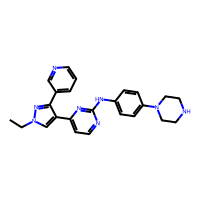
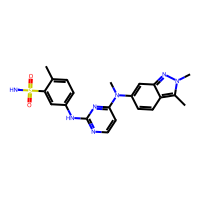
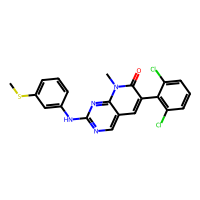
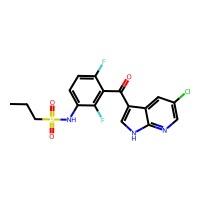
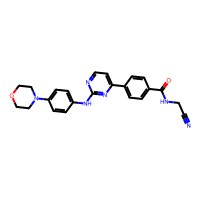
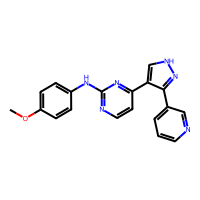
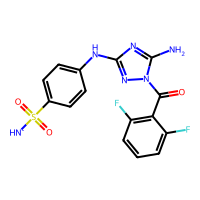
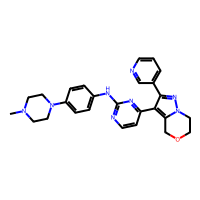

In [259]:
df_clusters = df.copy()
df_clusters['cluster'] = labels_TSNE
df_clusters['cluster'] = df_clusters['cluster'] + 1  # make sure all clusters are +1 to lign up with the UMAP plot
df_clusters = df_clusters.drop(columns=['morgan'])

# filter cluster column to only show 1 and 5
df_clusters = df_clusters[df_clusters['cluster'].isin([1])].reset_index(drop=True)
PandasTools.AddMoleculeColumnToFrame(frame=df_clusters, smilesCol='smiles')
df_clusters

In [227]:
# store pharmacophores based on clusters
import os
import shutil
import pandas as pd

# Directory containing the JSON files
json_dir = "../Results/pharmacophores"  # replace with actual path

# Ensure cluster folders exist and move files
for _, row in df_clusters.iterrows():
    cluster = row['cluster']
    name_prefix = row['name'][:4]  # first 3-4 characters
    cluster_folder = os.path.join(json_dir, f"cluster_{cluster}")
    os.makedirs(cluster_folder, exist_ok=True)

    # Find and move matching json files
    for file in os.listdir(json_dir):
        if file.endswith(".json") and file.startswith(name_prefix):
            src = os.path.join(json_dir, file)
            dst = os.path.join(cluster_folder, file)
            shutil.move(src, dst)


PLIPIFP version

In [260]:
from rdkit import DataStructs

def matrix_Tanimoto(mols):
    matrix = []
    fps = []

    for idx, mol in mols.iterrows():
        bitstring="".join(mol.values.astype(int).astype(str))
        fp2 = DataStructs.cDataStructs.CreateFromBitString(bitstring)
        fps.append(fp2)

    for fp in fps:
        #print(bitstring)
        array_similaridade = DataStructs.BulkTanimotoSimilarity(fp, fps)
        matrix.append(array_similaridade)
        
    return pd.DataFrame(data=matrix)


tanimoto = matrix_Tanimoto(df[[x for x in df.columns if x.endswith("_A")]])
tanimoto

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,1.000000,0.500000,0.428571,0.444444,0.133333,1.000000,0.571429,0.300000,0.444444,0.230769,...,0.454545,0.571429,0.250000,0.555556,0.600000,0.500000,0.272727,0.272727,0.076923,0.400000
1,0.500000,1.000000,0.181818,0.454545,0.176471,0.500000,0.555556,0.230769,0.600000,0.266667,...,0.583333,0.555556,0.384615,0.545455,0.583333,0.500000,0.416667,0.214286,0.133333,0.307692
2,0.428571,0.181818,1.000000,0.222222,0.071429,0.428571,0.285714,0.000000,0.222222,0.000000,...,0.166667,0.285714,0.083333,0.200000,0.400000,0.181818,0.090909,0.200000,0.000000,0.090909
3,0.444444,0.454545,0.222222,1.000000,0.125000,0.444444,0.333333,0.272727,0.400000,0.307692,...,0.416667,0.333333,0.230769,0.363636,0.700000,0.333333,0.363636,0.363636,0.153846,0.153846
4,0.133333,0.176471,0.071429,0.125000,1.000000,0.133333,0.230769,0.285714,0.200000,0.235294,...,0.166667,0.230769,0.176471,0.187500,0.235294,0.111111,0.117647,0.055556,0.266667,0.266667
5,1.000000,0.500000,0.428571,0.444444,0.133333,1.000000,0.571429,0.300000,0.444444,0.230769,...,0.454545,0.571429,0.250000,0.555556,0.600000,0.500000,0.272727,0.272727,0.076923,0.400000
6,0.571429,0.555556,0.285714,0.333333,0.230769,0.571429,1.000000,0.200000,0.714286,0.250000,...,0.500000,1.000000,0.400000,0.625000,0.500000,0.400000,0.300000,0.083333,0.181818,0.300000
7,0.300000,0.230769,0.000000,0.272727,0.285714,0.300000,0.200000,1.000000,0.166667,0.416667,...,0.214286,0.200000,0.142857,0.250000,0.307692,0.230769,0.250000,0.071429,0.250000,0.363636
8,0.444444,0.600000,0.222222,0.400000,0.200000,0.444444,0.714286,0.166667,1.000000,0.214286,...,0.545455,0.714286,0.454545,0.500000,0.545455,0.454545,0.363636,0.153846,0.153846,0.250000
9,0.230769,0.266667,0.000000,0.307692,0.235294,0.230769,0.250000,0.416667,0.214286,1.000000,...,0.250000,0.250000,0.187500,0.285714,0.333333,0.187500,0.285714,0.125000,0.285714,0.200000


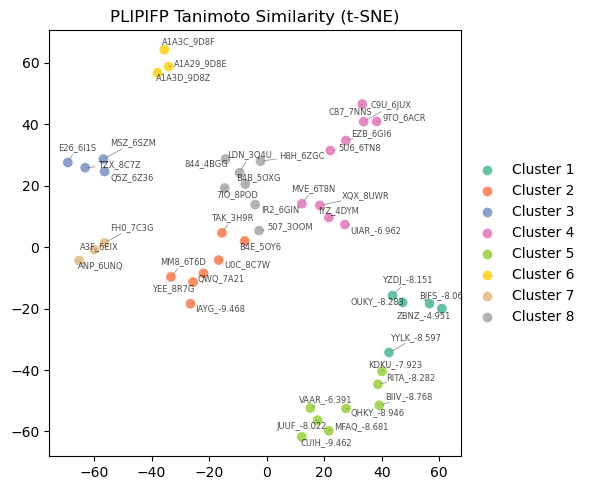

In [261]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from adjustText import adjust_text

tsne = TSNE(metric='precomputed', init='random', random_state=42, perplexity=3)
embedding_tsne = tsne.fit_transform(1 - tanimoto)

kmeans = KMeans(n_clusters=8, random_state=42)
labels_TSNE = kmeans.fit_predict(embedding_tsne)

cmap = plt.get_cmap('Set2')

plt.figure(figsize=(6, 5))
plt.scatter(embedding_tsne[:, 0], embedding_tsne[:, 1], c=cmap(labels_TSNE))
plt.title('PLIPIFP Tanimoto Similarity (t-SNE)')

texts = [plt.text(embedding_tsne[i, 0], embedding_tsne[i, 1], name, fontsize=6, alpha=0.7)
        for i, name in enumerate(df['name'])]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), force_text=1)


for i in range(8):
    plt.scatter([], [], color=cmap(i), label=f'Cluster {i+1}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.tight_layout()
plt.savefig("../Results/images/PLIPIFP clusters T-SNE (Vina).png", dpi=300)
plt.show()

/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/jelle/miniconda3/envs/spock/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


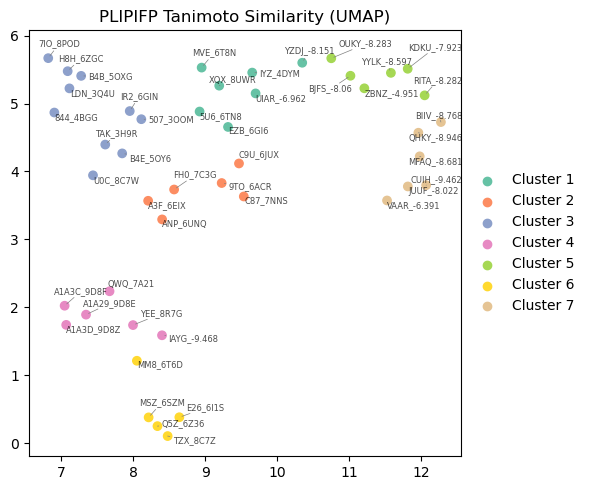

In [262]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Assuming your matrix is in a DataFrame called df
reducer = umap.UMAP(metric='precomputed', random_state=42, n_neighbors=5, min_dist=0.1)
embedding = reducer.fit_transform(1 - tanimoto)  # 1 - similarity = distance

kmeans = KMeans(n_clusters=7, random_state=42)
labels = kmeans.fit_predict(embedding)

cmap = plt.get_cmap('Set2')  # discrete colormap
colors = cmap(labels)

plt.figure(figsize=(6, 5))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors)

# Add labels for each molecule (replace molecule_names with your list)
texts = [plt.text(embedding[i, 0], embedding[i, 1], name, fontsize=6, alpha=0.7)
        for i, name in enumerate(df['name'])]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), force_text=1)


for i in range(7):
    plt.scatter([], [], color=cmap(i), label=f'Cluster {i+1}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.title('PLIPIFP Tanimoto Similarity (UMAP)')
plt.tight_layout()
plt.savefig("../Results/images/PLIP clusters UMAP (PLIPIFP).png", dpi=300)
plt.show()